# Analysis of the ExTRI2 resource

In [1]:
__import__('sys').path.append('../scripts/common/'); __import__('notebook_utils').table_of_contents('ExTRI2_results_analysis.ipynb')

<h3>Table of contents</h3>


[Analysis of the ExTRI2 resource](#Analysis-of-the-ExTRI2-resource)
- [Setup](#Setup)
- [The ExTRI2 resource](#The-ExTRI2-resource)

## Setup

In [12]:
# IMPORTS
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import upsetplot
import warnings
from analysis import *


from Bio import Entrez
# *Always* tell NCBI who you are
Entrez.email = "example24@gmail.com"

## Custom functions
import sys

sys.path.append('../scripts/common/')
from notebook_utils import table_of_contents, table_from_dict, h3, h4, h5, md
pd.set_option('display.max_colwidth', 20)

In [13]:
# LOAD & PREPROCESSING
config = load_config()

valid = pd.read_csv(config['final_ExTRI2_p'], sep="\t", dtype=str, keep_default_na=False)
valid['PMID+Sent'] = valid['#SentenceID'].apply(lambda row: row.split(':')[1]+'|'+row.split(':')[4])
valid['PMID+Sent+TRI'] = valid['PMID+Sent'] + '|' + valid['TF'] + '|' + valid['TG']
valid['TRI Id'] = valid['TF Id'] + '|' + valid['TG Id']
valid['PMID+Sent+TRI_Id'] = valid['PMID+Sent'] + '|' + valid['TRI Id']

In [5]:
# FUNCTIONS
def retrieve_annotations_entrez(id_list):
    """Annotates Entrez Gene IDs using Bio.Entrez, in particular epost (to
    submit the data to NCBI) and esummary to retrieve the information.
    Returns a list of dictionaries with the annotations."""

    request = Entrez.epost("gene", id=",".join(id_list))
    result = Entrez.read(request)
    webEnv = result["WebEnv"]
    queryKey = result["QueryKey"]
    data = Entrez.esummary(db="gene", webenv=webEnv, query_key=queryKey)
    annotations = Entrez.read(data)
    annotationsSummary = annotations['DocumentSummarySet']['DocumentSummary']

    assert len(id_list) == len(annotationsSummary), f"id_list and annotationsSummary are of different length: {len(id_list)} != {len(annotationsSummary)}"

    return annotationsSummary

def update_analytics(df):
    analytics = {}
    analytics['# sents'] = len(df)
    analytics['# blank TG Id'] = len(df[(df['TG Id'] == '') | (df['TG Id'] == 'None') | (df['TG Id'] == 'nan')])
    analytics['# mutated TF'] = (df['Mutated_TF'] == 'True').sum()
    analytics['Uniq PMIDs'] = set(df['PMID'])
    analytics['Uniq sent-TRI'] = set(df['PMID+Sent+TRI'])
    analytics['Uniq sent-TRI Id'] = set(df['PMID+Sent+TRI_Id'])
    analytics['Uniq TRI Id'] = set(df['TRI Id'])
    analytics['Uniq TF Id'] = set(df['TF Id'])
    analytics['Uniq TG Id'] = set(df['TG Id'])
    analytics['Human TF Id'] = set(df[df['TF TaxID'] == '9606']['TF Id'])
    analytics['Human TG Id'] = set(df[df['TG TaxID'] == '9606']['TG Id'])
    return analytics

def print_analytics(analytics):
    for key, value in analytics.items():
        if type(value) is set:
            num = len(value)
        else:
            num = value
        print(f"{key:<17}{num:,}")

## The ExTRI2 resource

In [14]:
# Get dbTFs_set
with open(config['dbTFs_p'], 'r') as f:
    dbTFs_set = {l.strip('\n') for l in f}

# Search for their name & TaxID
annotations_summary = retrieve_annotations_entrez(dbTFs_set)

# Make a map from symbol/TaxID to Gene ID
symboltoID_entrez = {'9606': {}, '10116': {}, '10090': {}}
for id, ann in zip(dbTFs_set, annotations_summary):
    symbol = ann['Name']
    TaxID = ann['Organism']['TaxID']

    if symbol not in symboltoID_entrez[TaxID]:
        symboltoID_entrez[TaxID][symbol] = [id]
    else:
        symboltoID_entrez[TaxID][symbol].append(id)

Entrez_human_dbTFs_set = {j for i in symboltoID_entrez['9606'].values() for j in i}

In [7]:
# Get analytics for valid sentences
valid_analytics = update_analytics(valid)
print_analytics(valid_analytics)

# sents          879,087
# blank TG Id    0
# mutated TF     3,563
Uniq PMIDs       311,466
Uniq sent-TRI    877,703
Uniq sent-TRI Id 878,876
Uniq TRI Id      288,520
Uniq TF Id       7,265
Uniq TG Id       26,097
Human TF Id      2,784
Human TG Id      12,480


Unique human TF IDs:    3084 (3084/1842 of all human TFs)
Unique human TF IDs:    3084 (3084/1842 of all human TFs)
Unique human TF Symbols:    3497 (190% of all human TFs)
2 more symbols than IDs: AP1 & NFKB


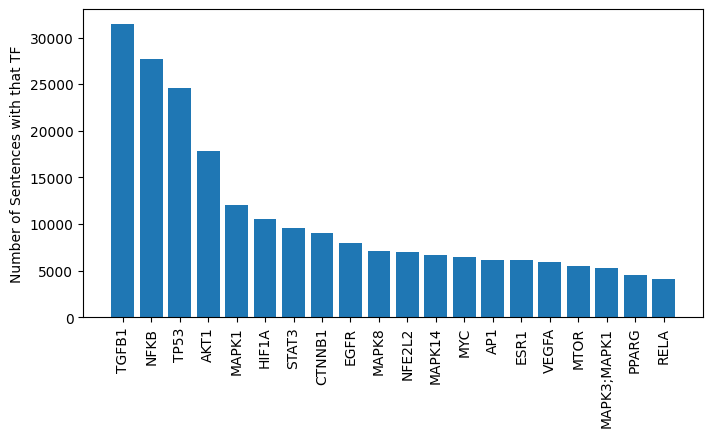

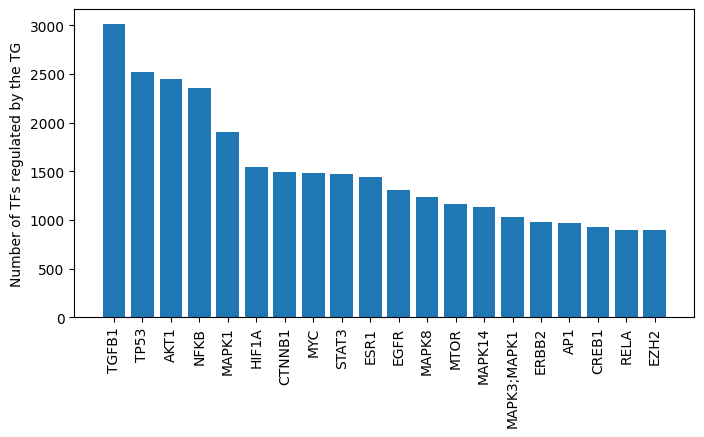

In [8]:
# HUMAN TFs ANALYSIS
# Filter by human dbTFs
valid_human = valid[(valid['TF TaxID'].str.contains('9606')) & (valid['TG TaxID'].str.contains('9606'))]

num_human_TFs = len(set(";".join(valid_human['TF Id'].unique()).split(";")))
print(f"Unique human TF IDs:    {num_human_TFs} ({num_human_TFs}/{len(Entrez_human_dbTFs_set)} of all human TFs)")
num_human_TFs = len(set(";".join(valid_human['TF Symbol'].unique()).split(";")))
print(f"Unique human TF IDs:    {num_human_TFs} ({num_human_TFs}/{len(Entrez_human_dbTFs_set)} of all human TFs)")
ExTRI2_human_TFs = set(valid_human['TF Symbol'])
print(f"Unique human TF Symbols:    {len(ExTRI2_human_TFs)} ({len(ExTRI2_human_TFs)/len(Entrez_human_dbTFs_set):.0%} of all human TFs)")
print("2 more symbols than IDs: AP1 & NFKB")

# Plot the most common dbTFs
def plot_counts(df, ylabel):
    counts = df['TF Symbol'].value_counts()
    plt.figure(figsize=(8,4))
    plt.bar(counts[:20].index, counts[:20])
    plt.xticks(rotation='vertical')
    plt.ylabel(ylabel)

plot_counts(valid_human, "Number of Sentences with that TF")
unique_TRIs = valid_human.drop_duplicates(subset='TRI Id', keep='first')
plot_counts(unique_TRIs, "Number of TFs regulated by the TG")
plt.show()

In [9]:
# ANALYSIS OF MOR
analysis = {
    'TOTAL': [],
    'UNDEFINED': [],
    'ACTIVATION': [],
    'REPRESSION': [],
    'Uniq. TRIs': [],
    'TRI maps to 1 MoR': [],
    'TRI maps to 2 MoR': [],
    'TRI maps to 3 MoR': []
}
mask = valid['Mutated_TF'] == 'True'
valid_mutated    = valid[mask]
valid_nonmutated = valid[~mask]
for df in (valid, valid_nonmutated, valid_mutated):
    analysis['TOTAL'].append(len(df))
    analysis['UNDEFINED'].append(len(df[df["MoR"] == 'UNDEFINED']))
    analysis['ACTIVATION'].append(len(df[df["MoR"] == 'ACTIVATION']))
    analysis['REPRESSION'].append(len(df[df["MoR"] == 'REPRESSION']))
    analysis['Uniq. TRIs'].append(df['TRI Id'].nunique())

    # Analyse whether TRIs get assigned more than 1 MoR.
    grouped = df.groupby('TRI Id')['MoR'].nunique()
    analysis['TRI maps to 1 MoR'].append((grouped == 1).sum())
    analysis['TRI maps to 2 MoR'].append((grouped == 2).sum())
    analysis['TRI maps to 3 MoR'].append((grouped == 3).sum())
    
    
analysis_df = pd.DataFrame.from_dict(analysis, orient='index', columns=['All valid', 'Non-mutated', 'Mutated'])
display(analysis_df.style.format('{:,}'))

# I want to create a table where I have: ACTIV, REPR, UNDEF & count how many TRIs are only ACTIV, ACTIV & REPR, etc.
# But I don't really need a table for that do I?
# I should create a upset plot?? why not right?? but I don't want to ...
# So: create the 3 sets

,All valid,Non-mutated,Mutated
TOTAL,"879,087","875,524","3,563"
UNDEFINED,"257,433","256,195","1,238"
ACTIVATION,"439,043","437,487","1,556"
REPRESSION,"182,611","181,842",769
Uniq. TRIs,"288,520","287,903","2,334"
TRI maps to 1 MoR,"211,156","210,783","2,035"
TRI maps to 2 MoR,"59,846","59,708",242
TRI maps to 3 MoR,"17,518","17,412",57


ACTIVATION  REPRESSION  UNDEFINED
True        False       False        98602
False       True        False        52949
            False       True         59605
True        True        False        11280
            False       True         35040
False       True        True         13526
True        True        True         17518
dtype: int64


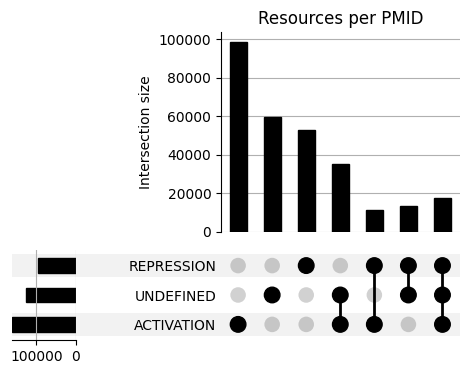

In [10]:
# CREATE UPSETPLOT FOR TRIs (ALL)
# Create a set of TRIs for each MoR
A_set = set(valid[valid["MoR"] == 'ACTIVATION']['TRI Id'])
R_set = set(valid[valid["MoR"] == 'REPRESSION']['TRI Id'])
U_set = set(valid[valid["MoR"] == 'UNDEFINED']['TRI Id'])
# 2. Get the union of these sets
MoR_listoflists = [
    ['ACTIVATION'], ['REPRESSION'], ['UNDEFINED'],
    ['ACTIVATION', 'REPRESSION'],
    ['ACTIVATION', 'UNDEFINED'],
    ['REPRESSION', 'UNDEFINED'],
    ['ACTIVATION', 'REPRESSION', 'UNDEFINED']
]
MoR_counts = [
    len(A_set - R_set - U_set), 
    len(R_set - A_set - U_set), 
    len(U_set - R_set - A_set),
    len((A_set & R_set) - U_set),
    len((A_set & U_set) - R_set),
    len((U_set & R_set) - A_set),
    len(A_set & R_set & U_set),    
]

# Ignore warnings for upsetplot: it has a lot (library seems like is not updated)
warnings.filterwarnings('ignore')
example = upsetplot.from_memberships(MoR_listoflists, data=MoR_counts)
upsetplot.plot(example)  # doctest: +SKIP
plt.title("Resources per PMID")
warnings.filterwarnings('default')
print(example)

ACTIVATION  REPRESSION  UNDEFINED
True        False       False        98602
False       True        False        52949
            False       True         59605
True        True        False        28798
            False       True         35040
False       True        True         13526
dtype: int64


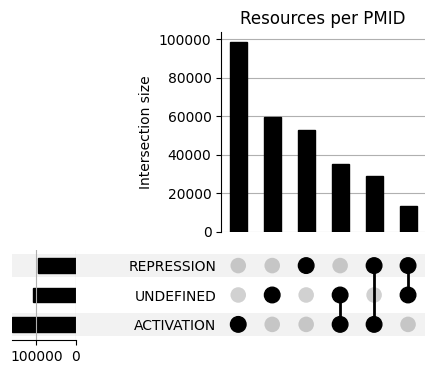

In [11]:
# CREATE UPSETPLOT FOR TRIs (ALL)
# Create a set of TRIs for each MoR
A_set = set(valid[valid["MoR"] == 'ACTIVATION']['TRI Id'])
R_set = set(valid[valid["MoR"] == 'REPRESSION']['TRI Id'])
U_set = set(valid[valid["MoR"] == 'UNDEFINED']['TRI Id'])
# 2. Get the union of these sets
MoR_listoflists = [
    ['ACTIVATION'], ['REPRESSION'], ['UNDEFINED'],
    ['ACTIVATION', 'REPRESSION'],
    ['ACTIVATION', 'UNDEFINED'],
    ['REPRESSION', 'UNDEFINED'],
]
MoR_counts = [
    len(A_set - R_set - U_set), 
    len(R_set - A_set - U_set), 
    len(U_set - R_set - A_set),
    len(A_set & R_set),
    len((A_set & U_set) - R_set),
    len((U_set & R_set) - A_set),
]

# Ignore warnings for upsetplot: it has a lot (library seems like is not updated)
warnings.filterwarnings('ignore')
example = upsetplot.from_memberships(MoR_listoflists, data=MoR_counts)
upsetplot.plot(example)  # doctest: +SKIP
plt.title("Resources per PMID")
warnings.filterwarnings('default')
print(example)